In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry, build_sam_vit_b_multiclass
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import nibabel as nib
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
import img2pdf
from torchmetrics import F1Score
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [4]:
class MRIDataset(Dataset): 
    def __init__(self, data_frame, label_id, bbox_shift=0):
        self.data_frame = data_frame
        self.bbox_shift = bbox_shift
        self.label_id = label_id
        #print(f'number of images: {data_frame.shape[0]}')
    
    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, index):
        
        # load image embedding as npy
        img_embed_path = self.data_frame.loc[index,'image_embedding_slice_path']
        img_embed_npy = np.load(img_embed_path) # (256, 64, 64)
        img_slice_name = '_slice'.join(img_embed_path.split('/')[-2:])

        # load segmentation mask as npy
        seg_path = self.data_frame.loc[index,'segmentation_slice_path']
        seg_npy = np.load(seg_path) # (256, 256)
        seg_npy = (seg_npy==self.label_id).astype(np.uint8) # (256, 256)

        assert np.max(seg_npy)<=1 and np.min(seg_npy)>=0, 'ground truth should be 0, 1'

        # load bounding box coordinates from data frame
        x_min, x_max = self.data_frame.loc[index, 'bbox_0'], self.data_frame.loc[index, 'bbox_2']
        y_min, y_max = self.data_frame.loc[index, 'bbox_1'], self.data_frame.loc[index, 'bbox_3']
        
        # add perturbation to bounding box coordinates
        H, W = seg_npy.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        return torch.tensor(img_embed_npy).float(), torch.tensor(seg_npy[None, :, :]).long(), torch.tensor(bboxes).float(), img_slice_name
    def load_image(self, index):
        img_path = self.data_frame.loc[index, 'image_path']
        slice_num = self.data_frame.loc[index, 'slice']
        img = nib.load(img_path).get_fdata()[:,slice_num,:].astype(np.uint8)
        return img # returns as (256, 256)


# code to load train, val, test datasets
def load_datasets(path_df_path, train_test_splits_path, label_id, bbox_shift=0, sample_n_slices = None):
    # load dataframe of slice paths
    path_df = pd.read_csv(path_df_path)

    # load train val test ids
    dicto = pickle.load(open(train_test_splits_path, 'rb'))
    train_ids = dicto['train']
    val_ids = dicto['val']
    test_ids = dicto['test']

    train_df = path_df[path_df['id'].isin(train_ids)].reset_index(drop=True)
    val_df = path_df[path_df['id'].isin(val_ids)].reset_index(drop=True)
    test_df = path_df[path_df['id'].isin(test_ids)].reset_index(drop=True)

    if sample_n_slices is not None:
        train_df = train_df.sample(n=sample_n_slices, replace=False, random_state=2023).reset_index(drop=True)
        val_df = val_df.sample(n=sample_n_slices, replace=False, random_state=2023).reset_index(drop=True)
        test_df = test_df.sample(n=sample_n_slices, replace=False, random_state=2023).reset_index(drop=True)

    train_dataset = MRIDataset(train_df, label_id, bbox_shift)
    val_dataset = MRIDataset(val_df, label_id, 0)
    test_dataset = MRIDataset(test_df, label_id, 0)

    return train_dataset, val_dataset, test_dataset
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    
    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().detach().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [5]:
def convert_medsam_checkpt_to_readable_for_sam(checkpt, to_save_dir = None):
    result = torch.load(checkpt)['model']

    # now remove t{he "module." prefix
    result_dict = {}
    for k,v in result.items():
        new_k = '.'.join(k.split('.')[1:])
        result_dict[new_k] = v
    if to_save_dir is not None:
        torch.save(result_dict, to_save_dir)
    return result_dict

def load_model(path, device = 'cuda'):
    model = sam_model_registry['vit_b'](checkpoint=path)
    model = model.to(device)
    model.eval()
    return model

In [6]:
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

In [4]:
# uncomment this block to re-generate medsam checkpoints that are readable for the SAM module

# path_1e4 = '/gpfs/home/kn2347/results/medsam_finetuning_model_checkpoints_7-18-23/MedSAM_finetune_hcp_ya_constant_bbox-20230721-230627/medsam_model_best.pth'
# path_1e3 = '/gpfs/home/kn2347/results/medsam_finetuning_model_checkpoints_7-18-23/MedSAM_finetune_hcp_ya_constant_bbox-20230724-014522/medsam_model_best.pth'
# path_1e5 = '/gpfs/home/kn2347/results/medsam_finetuning_model_checkpoints_7-18-23/MedSAM_finetune_hcp_ya_constant_bbox-20230721-133854/medsam_model_best.pth'
# path_ori_medsam ='/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth'
# #_ = convert_medsam_checkpt_to_readable_for_sam(path_1e4, to_save_dir = '/gpfs/home/kn2347/results/medsam_evaluating_models_first_pass_7-22-23/model_1e-4_best.pth')
# _ = convert_medsam_checkpt_to_readable_for_sam(path_1e3, to_save_dir = '/gpfs/home/kn2347/results/medsam_evaluating_models_first_pass_7-22-23/model_1e-3_best.pth')
# _ = convert_medsam_checkpt_to_readable_for_sam(path_1e5, to_save_dir = '/gpfs/home/kn2347/results/medsam_evaluating_models_first_pass_7-22-23/model_1e-5_best.pth')

In [8]:
path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'

_, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = 2, bbox_shift=0, sample_n_slices = None)

path_1e4 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_evaluating_models_first_pass_7-22-23/model_1e-4_best.pth'
path_1e3 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_evaluating_models_first_pass_7-22-23/model_1e-3_best.pth'
path_1e5 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_evaluating_models_first_pass_7-22-23/model_1e-5_best.pth'
path_ori_medsam ='/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth'
device = 'cuda'

medsam_model_1e3 = load_model(path_1e3, device)
medsam_model_1e4 = load_model(path_1e4)
medsam_model_1e5 = load_model(path_1e5)
ori_sam_model = load_model(path_ori_medsam)

In [26]:
def load_and_preprocess_slice(ds, img_idx, dev='cuda'):
    image_data = ds.load_image(img_idx)
    img_embedding, img_seg, img_box, slice_name = ds[img_idx]
    img_embedding, img_seg, img_box = img_embedding.to(dev), img_seg.to(dev), img_box.to(dev)

    # reshape for computation
    img_embedding = img_embedding[None, :, :, :]
    img_box = img_box.reshape((1,4))
    img_box_1024 = img_box * 4 # for ori model
    img_seg = img_seg.cpu().numpy()

    return image_data, img_embedding, img_box, img_box_1024, img_seg
def is_slice_blank(image_data):
    return np.abs(image_data).sum() == 0
def seg_get_class_indices(preds): # preds should be of shape (B, H, W) or (B, C, H, W)
    if not torch.is_tensor(preds):
        preds = torch.IntTensor(preds)
    assert not torch.is_floating_point(preds)  # must be class numbers

    if len(preds.shape) == 3:
        # this is 0's and 1's already, so good as is
        return preds[:, None, :, :]
    elif len(preds.shape) == 4:
        raise NotImplementedError

def dice_score_single_class(truth, pred, eps=1e-7):
    # B, 1, Rows, Columns for both truth and pred
    # values are 0 or 1: calculate overlap w.r.t. the 1
    B, classes, r, c = truth.size()
    assert classes == 1
    truth = truth.view(B, -1).cuda()
    pred = pred.view(B, -1).cuda()

    overlap_term = (truth * pred).sum(dim=1) * 2 + eps
    union_term = (truth + pred).sum(dim=1) + eps


    return (overlap_term / union_term).mean().cpu().item()

'''
def dice_score(truth, pred, eps=1e-7): # both have shape (B, C, 256, 256)
    N, C, sh1, sh2 = truth.size()   
    truth = truth.view(N,C,-1) # (N, C, sh1*sh2)

    N, C, sh1, sh2 = pred.size()
    pred = pred.view(N, C, -1)

    

    dice_class_score=0

    return dice_class_score

dice_score(arr1, arr2, eps=1e-7)
'''
#dice_score_single_class(arr1, arr2, eps=1e-7)

'\ndef dice_score(truth, pred, eps=1e-7): # both have shape (B, C, 256, 256)\n    N, C, sh1, sh2 = truth.size()   \n    truth = truth.view(N,C,-1) # (N, C, sh1*sh2)\n\n    N, C, sh1, sh2 = pred.size()\n    pred = pred.view(N, C, -1)\n\n    \n\n    dice_class_score=0\n\n    return dice_class_score\n\ndice_score(arr1, arr2, eps=1e-7)\n'

In [27]:
def run_model_on_dataset(model, test_ds, dest_H=256, dest_W=256, output_path = ''):
    # output should be pandas dataframe with paths to segmentations, as well as summary stats (e.g. dice scores w.r.t. ground truth)
    dataloader = DataLoader(
        test_ds,
        batch_size = 32,
        shuffle = False,
        num_workers = 1,
        pin_memory = True
    )
    list_ids = []
    list_slice_nums = []
    stats_lists = {'dice_score_with_ground_truth':[]}

    for step, (image_embedding, gt2D, boxes, slice_names) in enumerate(tqdm(dataloader)):

        image_embedding, gt2D, boxes = image_embedding.cuda(), gt2D.cuda(), boxes.cuda()
        medsam_pred = medsam_inference(model, image_embedding, boxes, dest_H, dest_W) # numpy (B, 256, 256)
        
        #print(medsam_pred.shape) # np arrqay of size (B, 256, 256), later generalize to (batches, classes, 256, 256)
        #print(gt2D.shape) # tensor of size (B, 1, 256, 256)
        
        medsam_pred = seg_get_class_indices(medsam_pred) # now (batches, classes, 256, 256)
        
        # generate stats here
        dice_score = dice_score_single_class(gt2D, medsam_pred, eps=1e-6)
        
        stats_lists['dice_score_with_ground_truth'].append(dice_score)
        # backmap using id's and slice nums
        # slice_names: list of B values formatted as '{id}_slice{slice_num}.npy'
        for i in range(len(slice_names)):
            list_ids.append(int(slice_names[i].split('_')[0]))
            list_slice_nums.append(int(slice_names[i].split('_')[1].split('.npy')[0].split('slice')[1]))
        
    return stats_lists
    

stats_list = run_model_on_dataset(medsam_model_1e4, val_dataset)
#print(sum(stats_list['dice_score_with_ground_truth']) / len(stats_list['dice_score_with_ground_truth']))



  1%|          | 5/888 [00:05<16:50,  1.14s/it]


KeyboardInterrupt: 

In [21]:
def plot_random_example(test_ds, model_list, names_list, dev='cuda', dest_H=256, dest_W=256, n_ex = 1, seed=182, restrict_to_label_present = True):
    np.random.seed(seed)
    # set up the plot
    fig, axs = plt.subplots(n_ex, len(model_list)+2, figsize=(25, 25)) # 0 index is ground truth segmentation
    
    for iter in range(n_ex):
        print(iter)
        while True:
            img_idx = np.random.randint(len(test_ds))

            # load image, embedding, segmentation, and input mask
            image_data, img_embedding, img_box, img_box_1024, img_seg = load_and_preprocess_slice(test_ds, img_idx, dev)

            # break if blank
            if is_slice_blank(image_data):
                continue
            
            seg_list = []

            # run inference
            for model in model_list:
                this_seg_result = medsam_inference(model, img_embedding, img_box, H=dest_H, W=dest_W) #(dest_H,dest_W)
                seg_list.append(this_seg_result)

            segmentation_mask_sum = sum([x.sum() for x in seg_list])
            total_sum = img_seg.sum() + segmentation_mask_sum
            if total_sum == 0: # neither ground truth nor segmentations have any predicted True's
                continue

            break
            
        # plot 
        
        image_data_3c = np.repeat(image_data[:,:,None], 3, axis=-1)

        axs[iter, 0].imshow(image_data_3c)
        if iter == 0:
            axs[iter, 0].set_title('Input Image', fontsize=20)
        axs[iter, 0].axis('off')

        axs[iter, 1].imshow(image_data_3c)
        show_mask(img_seg>0, axs[iter, 1])
        if iter == 0:
            axs[iter, 1].set_title('Ground Truth', fontsize=20)
        axs[iter, 1].axis('off')

        for i in range(len(model_list)):
            axs[iter, i+2].imshow(image_data_3c)
            show_mask(seg_list[i], axs[iter, i+2])
            show_box(img_box.flatten().cpu().numpy(), axs[iter, i+2])
            if iter==0:
                axs[iter, i+2].set_title(f'{names_list[i]} Segmentation', fontsize=20)
            axs[iter, i+2].axis('off')

    fig.show()
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, axs, seg_list

In [ ]:
save_path = '/gpfs/home/kn2347/results/medsam_finetuning_outputs_7-24_23'
for iter_idx in range(100):
    fig, axs, seg_list = plot_random_example(test_dataset, [medsam_model_1e3, medsam_model_1e4, medsam_model_1e5], ['lr=1e-3', 'lr=1e-4', 'lr=1e-5'], dev='cuda', dest_H=256, dest_W=256, n_ex=5, restrict_to_label_present=True, seed = iter_idx)
    fig.savefig(os.path.join(save_path, f'plot_{iter_idx}.png'), dpi=300)

In [27]:
rt = "/gpfs/home/kn2347/results/medsam_finetuning_outputs_7-24_23"
with open("/gpfs/home/kn2347/results/medsam_finetuning_outputs_7-24_23/results_model_output_7-24-23.pdf", 'wb') as f:
    list_paths = [f'{rt}/plot_{x}.png'for x in range(100)]
    f.write(img2pdf.convert(list_paths))

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an a

In [109]:
# randomly iterate over the dataset
num_iters = 10
for i in range(num_iters):
    # pick random example
    img_idx = np.random.randint(len(test_dataset))

    # load image, embedding, segmentation, and input mask
    image_data = test_dataset.load_image(img_idx)
    img_embedding, img_seg, img_box, slice_name = test_dataset[img_idx]
    img_embedding, img_seg, img_box = img_embedding.to(device), img_seg.to(device), img_box.to(device)

    # reshape for computation
    img_embedding = img_embedding[None, :, :, :]
    img_box = img_box.reshape((1,4))
    img_box_1024 = img_box * 4
    img_seg = img_seg.cpu().numpy()

    # run inference
    seg_result = medsam_inference(medsam_model_1e4, img_embedding, img_box, H=256, W=256)
    seg_result_ori_sam = medsam_inference(ori_sam_model, img_embedding, img_box_1024, H=256, W=256)





TypeError: Invalid shape (196608,) for image data

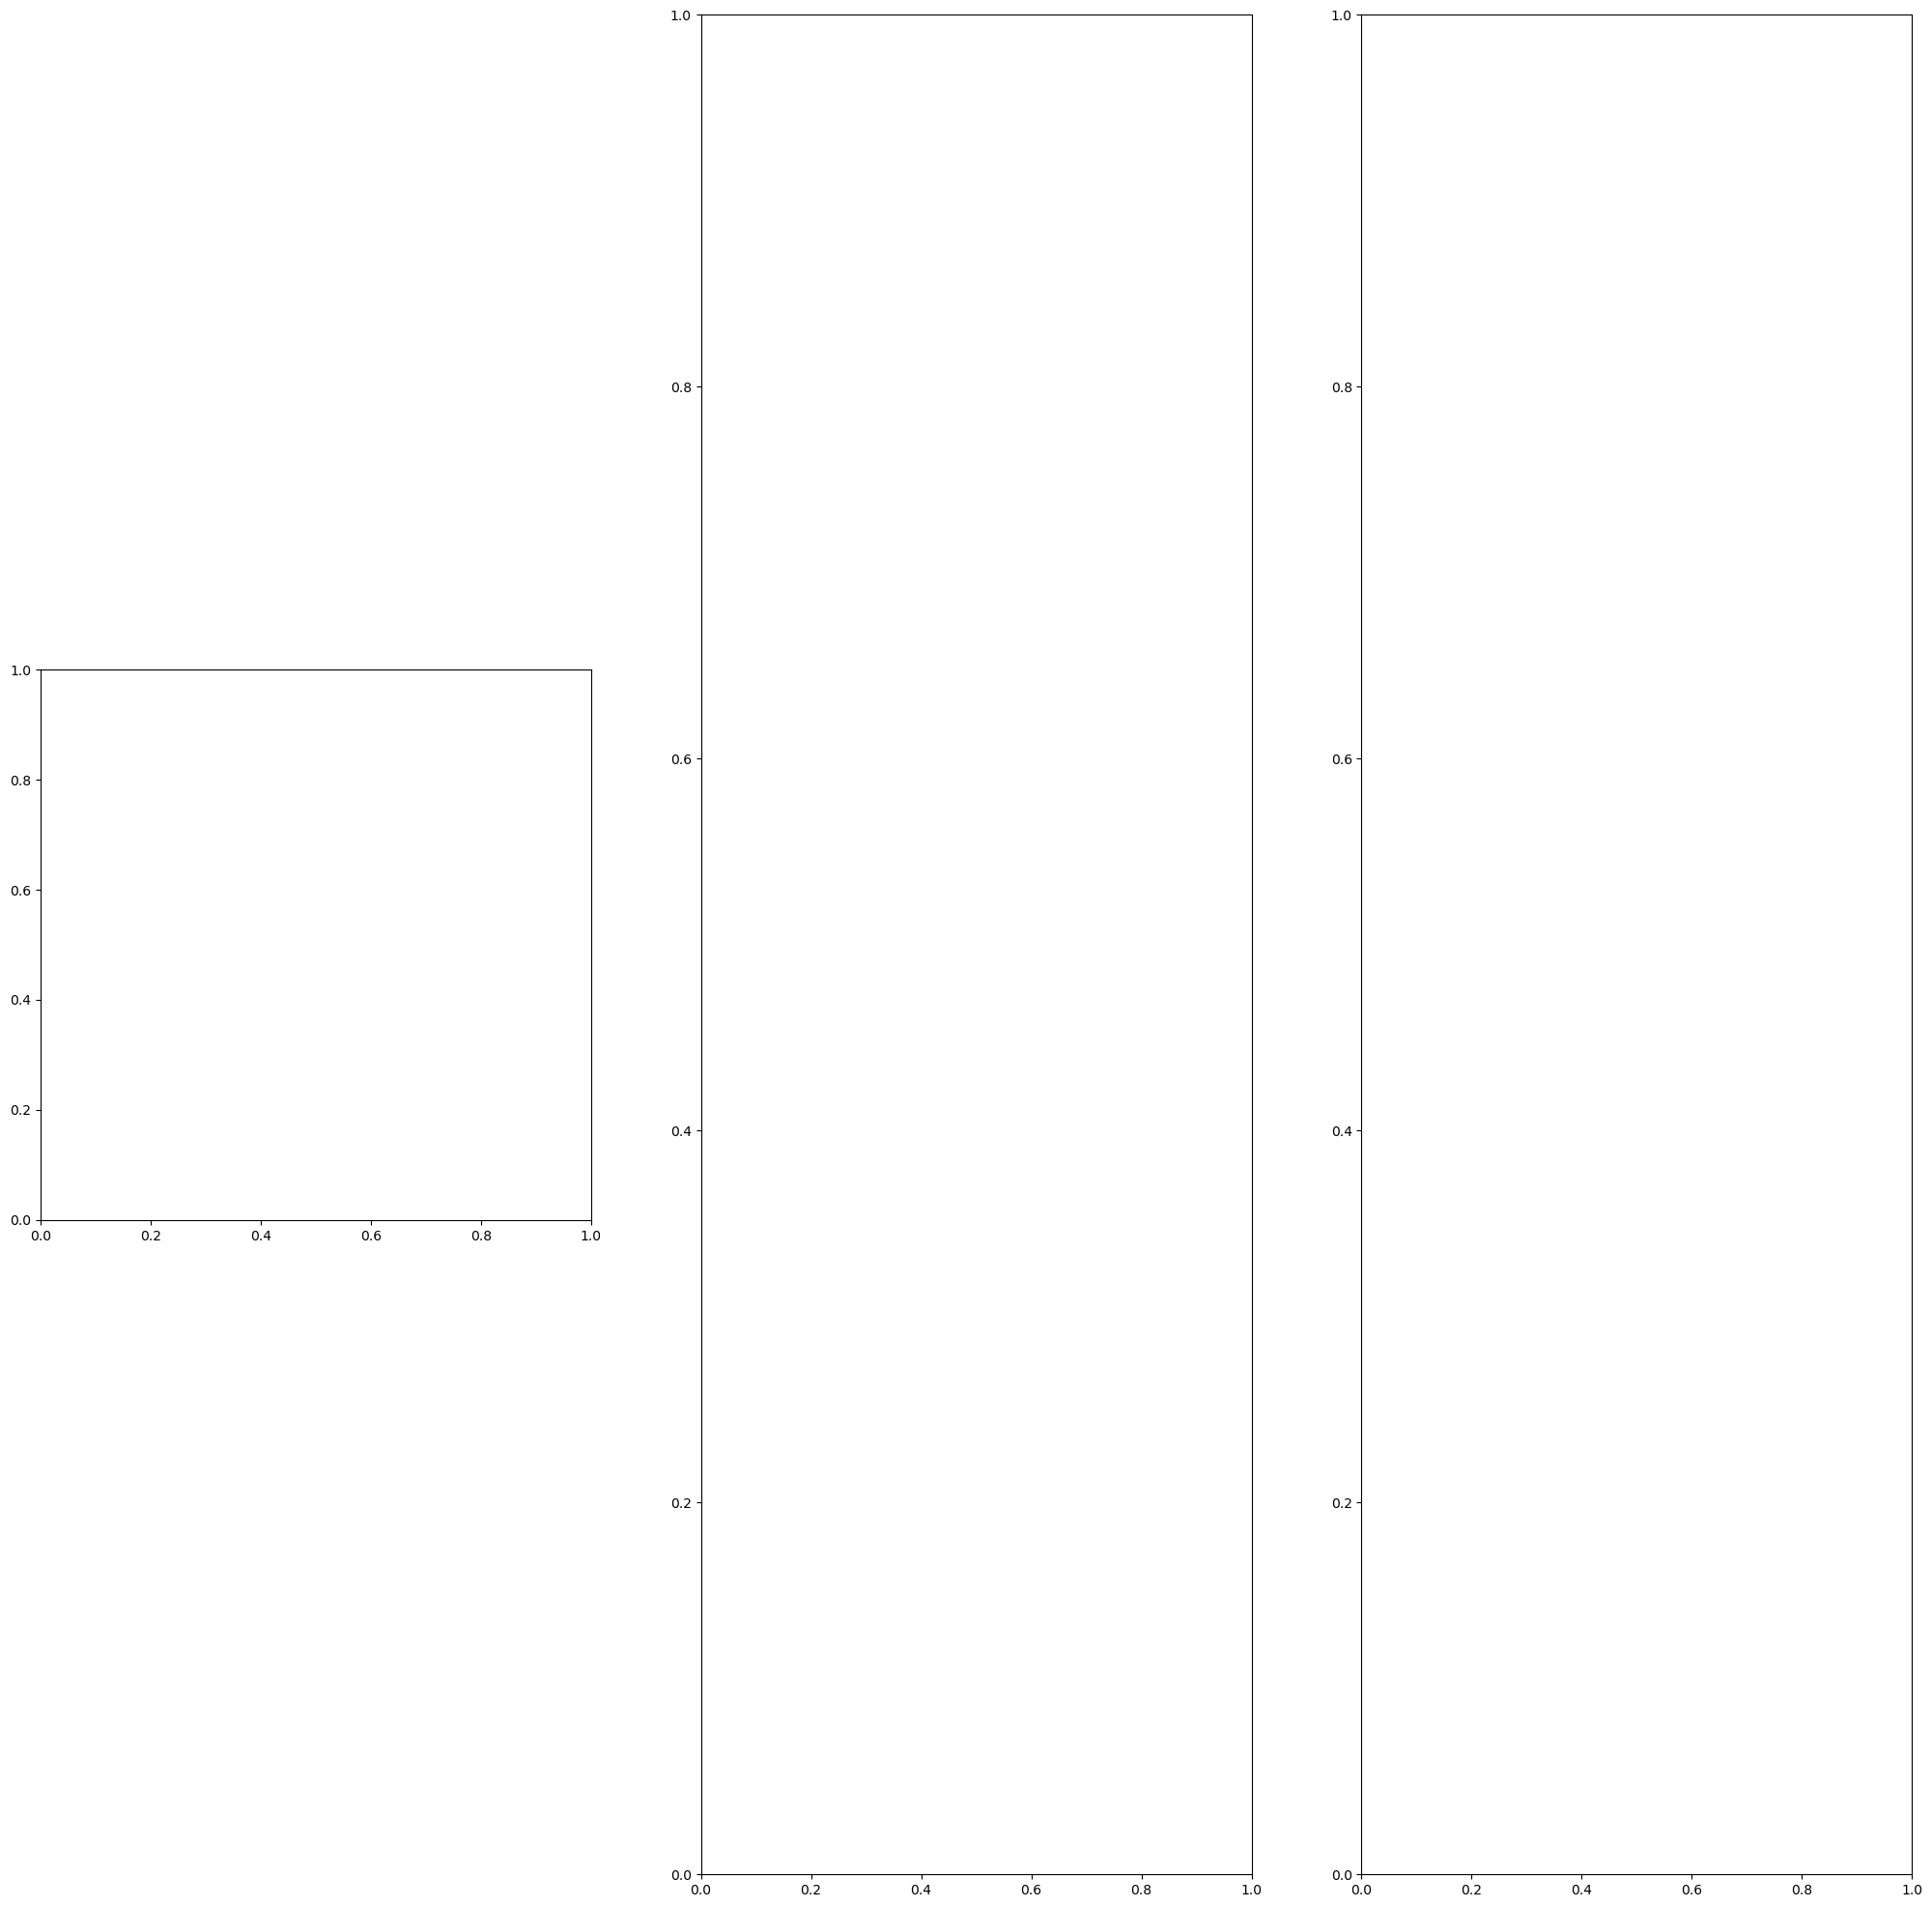

In [118]:
_, axs = plt.subplots(1, 3, figsize=(25, 25))

image_data_3c = np.repeat(image_data[:,:,None], 3, axis=-1)

axs[0].imshow(image_data_3c)
axs[0].set_title('Input Image', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data_3c)
show_mask(img_seg>0, axs[1])
axs[1].set_title('Ground Truth', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data_3c)
show_mask(seg_result, axs[2])
show_box(img_box.flatten().cpu().numpy(), axs[2])
axs[2].set_title('MedSAM Segmentation', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)

# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()